# CHE1147H A6 - Supervised learning
 
### 1. Model performance
The number of data points. Intuitively, more data points lead to better performance. But after some point, it is expected that the increase in model performance diminishes. 



##### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import imblearn
from imblearn.over_sampling import RandomOverSampler 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### 1.1 Dataset size vs model performance

Quantify the relationship between the dataset size and the model performance. 

Answer the question: how much data is enough to model client behaviour? In order to do this, you will pick the best single tree model you created in A5 and evaluate it with datasets of different sizes using the monthly features you created in A3. 

In [2]:
# monthly features:'monthly_features_outputs'

# Import files
mth_rolling_features = pd.read_excel("mth_rolling_features.xlsx")
mth_rolling_features = mth_rolling_features.drop(mth_rolling_features.columns[0], axis=1)
# fill nan with 0
mth_rolling_features = mth_rolling_features.fillna(0)
print('Demension of mth_rolling features:',mth_rolling_features.shape)

mth_day_counts = pd.read_excel("mth_day_counts.xlsx")
mth_day_counts = mth_day_counts.drop(mth_day_counts.columns[0], axis=1)
print('Demension of annual_day_of_week_counts_pivot:',mth_day_counts.shape)

days_since_last_txn = pd.read_excel("days_since_last_txn.xlsx")
days_since_last_txn = days_since_last_txn.drop(days_since_last_txn.columns[0], axis=1)
print('Demension of days_since_last_txn:',days_since_last_txn.shape,'\n')

Retail_Data_Response = pd.read_csv("Retail_Data_Response.csv")
Retail_Data_Response = Retail_Data_Response.rename(columns={'customer_id': 'CLNT_NO'}) 
print('Demension of Retail_Data_Response:',Retail_Data_Response.shape,'\n')

# Merge files on ['CLNT_NO','ME_DT']

monthly_features_outputs = pd.merge(mth_rolling_features, mth_day_counts ,on=['CLNT_NO','ME_DT'])
monthly_features_outputs = pd.merge(monthly_features_outputs, days_since_last_txn, on=['CLNT_NO','ME_DT'])

# Merge files on 'ME_DT'
monthly_features_outputs = pd.merge(Retail_Data_Response, monthly_features_outputs, on=['CLNT_NO'])
print('Demension of monthly_features_outputs:',monthly_features_outputs.shape)

print ("Check if the number of columns correct:", 
       monthly_features_outputs.shape[1] == (mth_rolling_features .shape[1] + mth_day_counts.shape[1] + days_since_last_txn.shape[1] 
       + Retail_Data_Response.shape[1] - 5))

monthly_features_outputs 

Demension of mth_rolling features: (323783, 22)
Demension of annual_day_of_week_counts_pivot: (323783, 9)
Demension of days_since_last_txn: (323783, 3) 

Demension of Retail_Data_Response: (6884, 2) 

Demension of monthly_features_outputs: (323548, 31)
Check if the number of columns correct: True


,CLNT_NO,response,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn
0,CS1112,0,2011-05-31,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,-10
1,CS1112,0,2011-06-30,56,1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,1,15
2,CS1112,0,2011-07-31,0,0,56.0,56.0,18.666667,1.0,1.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,46
3,CS1112,0,2011-08-31,96,1,96.0,152.0,50.666667,1.0,2.0,0.666667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,12
4,CS1112,0,2011-09-30,0,0,96.0,96.0,32.000000,1.0,1.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,0,2014-11-30,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,35.0,61.0,10.166667,1.0,2.0,0.333333,35.0,97.0,8.083333,1.0,4.0,0.333333,0,0,0,0,0,0,0,98
323544,CS9000,0,2014-12-31,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,35.0,61.0,10.166667,1.0,2.0,0.333333,35.0,97.0,8.083333,1.0,4.0,0.333333,0,0,0,0,0,0,0,129
323545,CS9000,0,2015-01-31,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,35.0,35.0,5.833333,1.0,1.0,0.166667,35.0,81.0,6.750000,1.0,3.0,0.250000,0,0,0,0,0,0,0,160
323546,CS9000,0,2015-02-28,34,1,34.0,34.0,11.333333,1.0,1.0,0.333333,34.0,34.0,5.666667,1.0,1.0,0.166667,35.0,115.0,9.583333,1.0,4.0,0.333333,0,0,1,0,0,0,0,0


##### 1. Split the train/test sets with 9:1 ratio This split should give you approximately 291k/32k samples in train/test set, respectively.

In [3]:
# Separate the inputs X and the output y  
X_monthly = monthly_features_outputs.drop(['response','CLNT_NO','ME_DT'],1)
y_monthly = monthly_features_outputs.response

# Split the data in train and test set. 
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=1/10, random_state=1147)

# 3. Pre-process data (standardized)
scaler = StandardScaler()
X_train_monthly = scaler.fit_transform(X_train_monthly)
X_test_monthly = scaler.transform(X_test_monthly)

print ('Train size: ', X_train_monthly.shape[0])
print ('Test size: ', X_test_monthly.shape[0])

Train size:  291193
Test size:  32355


Optimize tree model for different depths

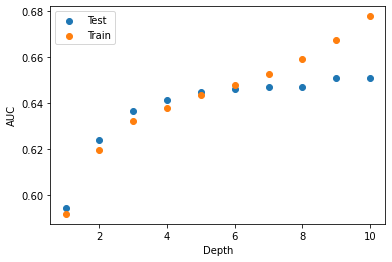

In [4]:
depths = list(range(1, 11))
Train_auc = np.zeros(shape=(len(depths),1))
Test_auc = np.zeros(shape=(len(depths),1))

count = -1
for depth in depths:
    count += 1
    # instantiate a tree classifier model, and fit with X and y
    single_tree = DecisionTreeClassifier(max_depth=depth, random_state=1147, class_weight='balanced')
    # Fit the model
    single_tree.fit(X_train_monthly, y_train_monthly)

    scores_train = single_tree.predict_proba(X_train_monthly)[:, 1]
    scores_test = single_tree.predict_proba(X_test_monthly)[:, 1]

    Train_auc[count,0] = roc_auc_score(y_train_monthly, scores_train)
    Test_auc[count,0]  = roc_auc_score(y_test_monthly, scores_test)
 

plt.scatter(depths, Test_auc, label='Test')
plt.scatter(depths, Train_auc, label='Train')
plt.xlabel('Depth')
plt.ylabel('AUC')
plt.legend()
plt.show()

# choose max_depth to 7, not overfitting and gives good test auc

In [5]:
# Best single tree model
single_tree = DecisionTreeClassifier(max_depth=7, random_state=1147,class_weight='balanced')

# Fit the model
single_tree.fit(X_train_monthly, y_train_monthly)

scores_train = single_tree.predict_proba(X_train_monthly)[:, 1]
scores_test = single_tree.predict_proba(X_test_monthly)[:, 1]

# auc score
Train_auc = roc_auc_score(y_train_monthly, scores_train)
Test_auc = roc_auc_score(y_test_monthly, scores_test)
 
print ('Train auc', Train_auc)
print ('Test auc', Test_auc)

Train auc 0.6524251785291771
Test auc 0.646871982345093


##### 2. Initialize and create a for loop in which you take N samples (e.g. 50), build a tree model with the N samples and evaluate the test set AUC. Repeat the sampling process 10 times and append the test set AUC. The following table shows the desired output:

|N = 50 samples|-|
|--|-|
|sample |Test AUC|
|1 | 0.545 |
|2 | 0.561|
|... | ...|
|10 |0.551|

From this table, you can calculate the mean and standard deviation of the test AUC for N samples.

In [6]:
# concat features and target, prepare for sampling
train_sample = pd.concat([pd.DataFrame(X_train_monthly),pd.DataFrame(y_train_monthly).reset_index(drop=True)],axis=1) 
train_sample.shape

(291193, 29)

In [9]:
def compute_test_auc (N):
  # input: take N samples randomly from standardized train data

  Test_auc_list = []
  for i in range(10):
    # random sample
    train_monthly_sample = train_sample.sample(frac=N/ train_sample.shape[0]).reset_index(drop=True)

    X_train_monthly_sample = train_monthly_sample.drop(['response'],1)
    y_train_monthly_sample = train_monthly_sample.response

    # Fit the model
    single_tree.fit(X_train_monthly_sample, y_train_monthly_sample)
    
    # Test auc
    scores_test = single_tree.predict_proba(X_test_monthly)[:, 1]
    Test_auc_list.append(roc_auc_score(y_test_monthly, scores_test).round(4))
    
    # Train auc
    # scores_train = single_tree.predict_proba(X_train_monthly_sample)[:, 1]
    # Train_auc = roc_auc_score(y_train_monthly_sample, scores_train)

    # calculate the mean and standard deviation of the test AUC for N samples
    Test_auc_mean = np.mean(Test_auc_list)
    Test_auc_sd = np.std(Test_auc_list)

  return Test_auc_list, Test_auc_mean, Test_auc_sd

In [13]:
# create table contains Test AUC of 10 trails
Test_auc_list, Test_auc_mean, Test_auc_sd = compute_test_auc (N=50)

result1_table = {'sample': np.arange(1,11),
                 'Test AUC': Test_auc_list}
pd.DataFrame (result1_table).style.hide_index()

sample,Test AUC
1,0.510800
2,0.494000
3,0.511600
4,0.504500
5,0.513500
6,0.523200
7,0.510100
8,0.511900
9,0.500500
10,0.497100


In [11]:
# calculate the mean and standard deviation of the test AUC for N samples
print ('mean of the test AUC for 50 samples', Test_auc_mean)
print ('sd of the test AUC for 50 samples', Test_auc_sd)

mean of the test AUC for 50 samples 0.5099
sd of the test AUC for 50 samples 0.009956505411036551


#####  3. Repeat the procedure you performed in the previous step for different sample size N (e.g. 100, 500, 1000, 2000, 5000, 10000) 

In [19]:
# total train set size before sampling: 291193
sample_size = np.arange(0,291193,5000)[1:]

# sample_size = [100,500,1000,2000,3000,4000,5000,6000,10000,20000]
mean_list = []
sd_list = []
for i in sample_size:
  Test_auc_list, Test_auc_mean, Test_auc_sd = compute_test_auc (N=i)
  mean_list.append(Test_auc_mean)
  sd_list.append(Test_auc_sd)

##### 4. Build a table that contains the values of:
*   Sample size N
*   Test AUC mean
*   Test AUC standard deviation

In [21]:
result2_table = {'Sample size N  ': sample_size,
                'Test AUC mean  ': mean_list,
                'Test AUC standard deviation ': sd_list}
pd.DataFrame (result2_table).style.hide_index()

Sample size N,Test AUC mean,Test AUC standard deviation
5000,0.576990,0.010176
10000,0.598400,0.011601
15000,0.606650,0.005092
20000,0.614890,0.006868
25000,0.614940,0.005130
30000,0.621120,0.006848
35000,0.625410,0.003963
40000,0.626720,0.003792
45000,0.628410,0.004782
50000,0.628560,0.003236


##### 5. Using the matplotlib function errorbar, plot the model performance captured in the test AUC mean and standard deviation as a function of the sample size. From this plot, can you estimate what is the minimum number of samples needed to model the behaviour adequately?

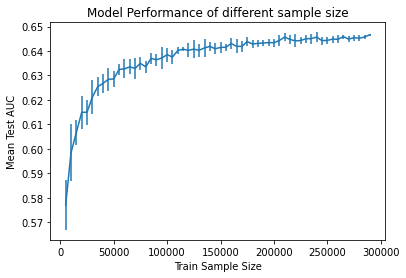

In [22]:
# Plotting
plt.errorbar(sample_size, mean_list, yerr=sd_list) 
plt.title('Model Performance of different sample size')
plt.ylabel('Mean Test AUC')
plt.xlabel('Train Sample Size')
plt.show()

# The knee of the curve at train sample size around 50000, after that point, the mean test auc increase slower, and the 
# test auc standard deviation is small. So, estimate at least 50000 samples are needed.